In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D, Bidirectional, GRU, Flatten, Dropout
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

## Import Dataset

In [3]:
fake = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/Fake.csv')
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [5]:
real = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/main/data/True.csv')
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [6]:
unknown_publishers = []
for index, row in enumerate(real.text.values):
    try:
        record = row.split('-',maxsplit=1)
        record[1]
        assert(len(record[0]) < 120)
    except:
        unknown_publishers.append(index)

In [7]:
len(unknown_publishers)

222

In [8]:
real.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 222, dtype: object

In [ ]:
real.iloc[8970]

title      Graphic: Supreme Court roundup
text                                     
subject                      politicsNews
date                       June 16, 2016 
Name: 8970, dtype: object

In [ ]:
real = real.drop(8970, axis = 0)

In [9]:
publisher = []
tmp_text = []

for index,row in enumerate(real.text.values):
    if index in unknown_publishers:
        tmp_text.append(row)
        publisher.append('unknown')
    else:
        record = row.split('-',maxsplit=1)
        publisher.append(record[0].strip())
        tmp_text.append(record[1].strip())

In [10]:
real['publisher'] = publisher
real['text'] = tmp_text

In [11]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [12]:
real.shape

(21417, 5)

In [13]:
empty_fake_index = [index for index,text in enumerate(fake.text.tolist()) if str(text).strip() == ""]

In [14]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [15]:
real['text'] = real['title'] + " " + real['text']
fake['text'] = fake['title'] + " " + fake['text']

In [16]:
real['text'] = real['text'].apply(lambda x: str(x).lower())
fake['text'] = fake['text'].apply(lambda x: str(x).lower())

## Preprocessing Text

In [17]:
real['class'] = 1
fake['class'] = 0

In [18]:
real.columns

Index(['title', 'text', 'subject', 'date', 'publisher', 'class'], dtype='object')

In [19]:
real = real[['text','class']]
fake = fake[['text','class']]

In [20]:
data = real.append(fake,ignore_index = True)
data.sample(6)

,text,class
36857,(video) huckster al sharpton: climate change i...,0
15276,spain could again revise down 2018 growth fore...,1
23075,"paul ryan breaks down, admits gop’s trumpcare...",0
30817,crooked democrat congresswoman corrine brown f...,0
2138,trump adviser bannon says u.s. in economic war...,1
33401,paul joseph watson exposes lunacy of leftists ...,0


In [ ]:
!pip install spacy==2.2.3
!python -m spacy download en_core_web_sm
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3

     |████████████████████████████████| 10.4 MB 532 kB/s            
     |████████████████████████████████| 184 kB 45.4 MB/s            
     |████████████████████████████████| 2.2 MB 39.9 MB/s            
     |████████████████████████████████| 3.7 MB 23.0 MB/s            
  Attempting uninstall: srsly
    Found existing installation: srsly 2.4.2
    Uninstalling srsly-2.4.2:
      Successfully uninstalled srsly-2.4.2
  Attempting uninstall: blis
    Found existing installation: blis 0.7.5
    Uninstalling blis-0.7.5:
      Successfully uninstalled blis-0.7.5
  Attempting uninstall: thinc
    Found existing installation: thinc 8.0.13
    Uninstalling thinc-8.0.13:
      Successfully uninstalled thinc-8.0.13
  Attempting uninstall: catalogue
    Found existing installation: catalogue 2.0.6
    Uninstalling catalogue-2.0.6:
      Successfully uninstalled catalogue-2.0.6
  Attempting uninstall: spacy
    Found existing installation: spacy 3.1.4
    Uninstalling spacy-3.1.4:
      Succes

In [21]:
def _remove_special_chars(x):
    x = re.sub(r'[^\w ]+', "", x)
    x = ' '.join(x.split())
    return x

In [22]:
data['text'] = data['text'].apply(lambda x: _remove_special_chars(x))

# Keras Embeddings

In [23]:
X_train, X_test, y_train, y_test = train_test_split(data['text'],data['class'], test_size=0.2, random_state=111)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(35918,) (35918,) (8980,) (8980,)


In [24]:
vocab_size = 10000
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

In [25]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [26]:
max_length = 120
trunc_type = 'post'
pad_type = 'post'

X_train_padded = pad_sequences(X_train, maxlen=max_length, truncating=trunc_type, padding=pad_type)
X_test_padded = pad_sequences(X_test, maxlen=max_length, truncating=trunc_type, padding=pad_type)

In [27]:
print(X_train_padded.shape, X_test_padded.shape)

(35918, 120) (8980, 120)


In [28]:
print(type(X_train_padded), type(X_test_padded))
print(type(y_train), type(y_test))
y_train = np.array(y_train)
y_test = np.array(y_test)
print(type(X_train_padded), type(X_test_padded))
print(type(y_train), type(y_test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [29]:
embedding_dim = 300
model = Sequential()
# define CNN model
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
# define LSTM model
model.add(Bidirectional(GRU(32, return_sequences=True)))
#model.add(GRU(32, return_sequences=True))
##model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
##model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

In [30]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(
    loss = "binary_crossentropy",
    optimizer = optimizer,
    metrics = ["accuracy"]
)

In [31]:
filepath = 'my_checkpoint.ckpt'
cp = ModelCheckpoint(
    filepath=filepath,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_accuracy',
    verbose=1
)

In [32]:
ep = EarlyStopping(
    monitor='val_accuracy', 
    patience=7,
)

In [33]:
epochs=25
history = model.fit(
    X_train_padded, y_train,
    validation_split = 0.2,
    callbacks=[cp,ep],
    batch_size=128,
    epochs=epochs
)

Epoch 1/25
225/225 [==============================] - ETA: 0s - loss: 0.2860 - accuracy: 0.8756
Epoch 00001: val_accuracy improved from -inf to 0.97842, saving model to my_checkpoint.ckpt
225/225 [==============================] - 24s 46ms/step - loss: 0.2860 - accuracy: 0.8756 - val_loss: 0.0653 - val_accuracy: 0.9784
Epoch 2/25
225/225 [==============================] - ETA: 0s - loss: 0.0327 - accuracy: 0.9898
Epoch 00002: val_accuracy improved from 0.97842 to 0.98524, saving model to my_checkpoint.ckpt
225/225 [==============================] - 9s 39ms/step - loss: 0.0327 - accuracy: 0.9898 - val_loss: 0.0443 - val_accuracy: 0.9852
Epoch 3/25
225/225 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9976
Epoch 00003: val_accuracy improved from 0.98524 to 0.98650, saving model to my_checkpoint.ckpt
225/225 [==============================] - 9s 39ms/step - loss: 0.0117 - accuracy: 0.9976 - val_loss: 0.0418 - val_accuracy: 0.9865
Epoch 4/25
225/225 [=============

In [34]:
model.evaluate(X_test_padded, y_test)

281/281 [==============================] - 3s 10ms/step - loss: 0.0498 - accuracy: 0.9884


[0.04979019612073898, 0.988418698310852]

In [35]:
predictions = (model.predict(X_test_padded) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, predictions)
print("Testing Accuracy: ", accuracy)

Testing Accuracy:  0.9884187082405346


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


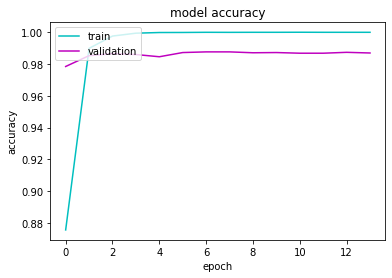

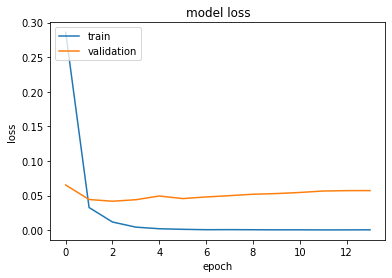

In [36]:
print(history.history.keys())
plt.axes().set(facecolor ="white")
plt.plot(history.history['accuracy'],color='c')
plt.plot(history.history['val_accuracy'],color='m')
plt.title('model accuracy').set_color('black')
plt.ylabel('accuracy').set_color('black')
plt.xlabel('epoch').set_color('black')
plt.legend(['train', 'validation'], loc='upper left')

plt.show()

plt.axes().set(facecolor ="white")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left')
plt.title('model loss').set_color('black')
plt.ylabel('loss').set_color('black')
plt.xlabel('epoch').set_color('black')
plt.show()

Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0    0.98799   0.98969   0.98884      4656
           1    0.98888   0.98705   0.98796      4324

    accuracy                        0.98842      8980
   macro avg    0.98844   0.98837   0.98840      8980
weighted avg    0.98842   0.98842   0.98842      8980



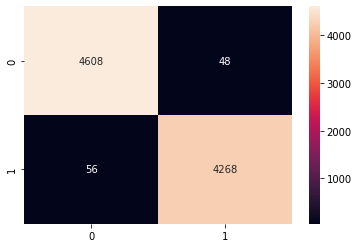

In [37]:
print('Confusion Matrix')
cm = confusion_matrix(y_test, predictions)
print(sns.heatmap(confusion_matrix(y_test, predictions),annot=True,fmt="d"))
print(classification_report(y_test, predictions, digits=5))

In [38]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from textblob import Word
sw=stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [39]:
def preprocess_tweet(new_tweet):    
    new_tweet = new_tweet.lower()
    new_tweet = re.sub('[^\w\s]', '', new_tweet)
    new_tweet = re.sub('\d', '', new_tweet)

    new_tweet = " ".join(x for x in new_tweet.split() if x not in sw)
    new_tweet = " ".join([Word(word).lemmatize() for word in new_tweet.split()])
    print("On processing:", new_tweet)
    
    tokenizer.fit_on_texts(new_tweet)

    new_tweet = tokenizer.texts_to_sequences([new_tweet])

    new_tweet =  pad_sequences(new_tweet, maxlen=max_length, truncating=trunc_type, padding=pad_type)

    return new_tweet

def predict_newTweet(tweet):
    print("Input Tweet: ", tweet)
    emb_tweet = preprocess_tweet(tweet)
    result = (model.predict(emb_tweet) > 0.5).astype("int32")
#     print(result)
    print("Output: " + "Real News" if result[0][0] == 1 else "Fake News")

In [42]:
new_tweet = "The Senior US Republican said Congressional Republicans reached a deal on final tax legislation on Wednesday, clearing the way for final votes next week on a package that would slash the U.S. corporate tax rate to 21 percent and cut taxes for wealthy Americans.  Under an agreement between the House of Representatives and the Senate, the corporate tax would be 1 percentage point higher than the 20 percent rate earlier proposed, but still far below the current headline rate of 35 percent, a deep tax reduction that corporations have sought for years. As they finalized the biggest tax overhaul in 30 years, Republicans wavered for weeks on whether to slash the top income tax rate for the wealthy.."
predict_newTweet(new_tweet)

Input Tweet:  The Senior US Republican said Congressional Republicans reached a deal on final tax legislation on Wednesday, clearing the way for final votes next week on a package that would slash the U.S. corporate tax rate to 21 percent and cut taxes for wealthy Americans.  Under an agreement between the House of Representatives and the Senate, the corporate tax would be 1 percentage point higher than the 20 percent rate earlier proposed, but still far below the current headline rate of 35 percent, a deep tax reduction that corporations have sought for years. As they finalized the biggest tax overhaul in 30 years, Republicans wavered for weeks on whether to slash the top income tax rate for the wealthy..
On processing: senior u republican said congressional republican reached deal final tax legislation wednesday clearing way final vote next week package would slash u corporate tax rate percent cut tax wealthy american agreement house representative senate corporate tax would percenta

In [43]:
new_tweet = "Fox Host Calls For A ‘Cleansing’ Of The FBI, And To Arrest Everyone Investigating Trump"
predict_newTweet(new_tweet)

Input Tweet:  Fox Host Calls For A ‘Cleansing’ Of The FBI, And To Arrest Everyone Investigating Trump
On processing: fox host call cleansing fbi arrest everyone investigating trump
Fake News


# Word2Vec Exploration

In [45]:
import gensim

In [ ]:
y = data['class'].values

In [47]:
DIM = 100
X = [d.split() for d in data['text'].tolist()]
w2v_model = gensim.models.Word2Vec(sentences = X, size = DIM, window = 10, min_count = 1)

In [49]:
w2v_model.wv['highest']

array([-2.9916635 ,  0.01718235, -0.5264771 ,  3.5512083 , -6.671092  ,
        0.20187782,  2.3779604 ,  2.6860175 ,  2.6145847 ,  1.4013104 ,
        1.2728559 ,  2.2969406 , -2.513135  ,  4.095384  , -1.1309563 ,
       -1.2912122 , -2.0007958 , -1.2550261 , -0.3442755 , -3.889283  ,
        0.5752788 ,  1.5680388 , -1.2938542 , -2.1342666 ,  0.41933268,
       -0.44769186,  0.39326653, -1.5151919 , -2.5724049 , -0.6375334 ,
       -2.2897658 , -5.1715283 ,  0.43699786, -1.1319838 ,  0.52900225,
       -1.0870613 ,  2.9763718 , -2.9031022 ,  1.6371266 ,  1.6656125 ,
       -0.49394664,  2.0570576 ,  0.42930976, -1.3735886 ,  0.9747827 ,
       -0.20243476,  0.5211709 ,  3.0723488 , -1.933673  ,  0.6460346 ,
       -1.8143846 , -2.2666173 ,  1.714728  , -1.5124353 ,  1.0023245 ,
        0.4268633 ,  1.4563121 , -0.21842648, -0.8396776 ,  0.39580983,
       -2.0375907 , -1.8397175 , -3.7094326 , -1.5035176 ,  0.18860479,
       -0.80386287, -1.9836057 ,  1.856323  ,  2.146316  ,  0.07

In [50]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [51]:
X = tokenizer.texts_to_sequences(X)

In [52]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'a': 4,
 'and': 5,
 'in': 6,
 'that': 7,
 'on': 8,
 'for': 9,
 's': 10,
 'is': 11,
 'he': 12,
 'said': 13,
 'trump': 14,
 'it': 15,
 'with': 16,
 'was': 17,
 'as': 18,
 'his': 19,
 'by': 20,
 'has': 21,
 'be': 22,
 'have': 23,
 'not': 24,
 'from': 25,
 'this': 26,
 'at': 27,
 'are': 28,
 'who': 29,
 'us': 30,
 'an': 31,
 'they': 32,
 'i': 33,
 'but': 34,
 'we': 35,
 'would': 36,
 'president': 37,
 'about': 38,
 'will': 39,
 'their': 40,
 'had': 41,
 'you': 42,
 't': 43,
 'been': 44,
 'were': 45,
 'people': 46,
 'more': 47,
 'or': 48,
 'after': 49,
 'which': 50,
 'she': 51,
 'her': 52,
 'one': 53,
 'if': 54,
 'its': 55,
 'out': 56,
 'all': 57,
 'what': 58,
 'state': 59,
 'when': 60,
 'new': 61,
 'also': 62,
 'up': 63,
 'there': 64,
 'over': 65,
 'no': 66,
 'house': 67,
 'donald': 68,
 'our': 69,
 'states': 70,
 'clinton': 71,
 'obama': 72,
 'government': 73,
 'can': 74,
 'just': 75,
 'him': 76,
 'so': 77,
 'than': 78,
 'republican': 79,
 'other': 80,
 'so

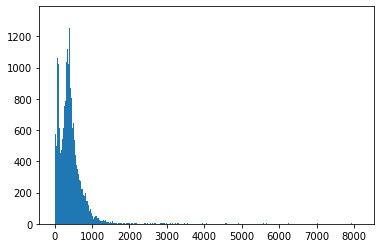

In [53]:
plt.hist([len(x) for x in X ], bins = 700 )
plt.show()

In [54]:
nos = np.array([len(x) for x in X])
len(nos[nos>1000])

1584

In [55]:
max_len = 1000
X = pad_sequences(X, maxlen = max_len)

In [56]:
vocab_size = len(tokenizer.word_index) + 1 # for unknown words

In [57]:
vocab = tokenizer.word_index

In [58]:
def get_weight_matrix(model):
    weight_matrix = np.zeros((vocab_size, DIM))

    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]

    return weight_matrix

In [59]:
embedding_vectors = get_weight_matrix(w2v_model)

In [60]:
embedding_vectors.shape

(231912, 100)

In [61]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten, GlobalAveragePooling1D
model = Sequential()
model.add(Embedding(vocab_size, output_dim = DIM, weights = [embedding_vectors], input_length = max_len, trainable = True))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
#model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
#model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

In [62]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 100)         23191200  
                                                                 
 conv1d_1 (Conv1D)           (None, 993, 32)           25632     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 496, 32)          0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 496, 64)          16640     
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 31744)             0         
                                                                 
 dense_2 (Dense)             (None, 32)               

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,data['class'], test_size=0.2, random_state=111)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(35918, 1000) (35918,) (8980, 1000) (8980,)


In [64]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss = "binary_crossentropy",optimizer = optimizer,metrics = ["accuracy"])
filepath = 'my_checkpoint.ckpt'
cp = ModelCheckpoint(filepath=filepath,save_weights_only=True,save_best_only=True,monitor='val_accuracy',verbose=1)
ep = EarlyStopping(monitor='val_accuracy', patience=7,)

In [65]:
epochs=25
history = model.fit(
    X_train, y_train,
    validation_split = 0.2,
    callbacks=[cp,ep],
    batch_size=128,
    epochs=epochs
)

Epoch 1/25
225/225 [==============================] - ETA: 0s - loss: 0.2362 - accuracy: 0.9052
Epoch 00001: val_accuracy improved from -inf to 0.95045, saving model to my_checkpoint.ckpt
225/225 [==============================] - 49s 196ms/step - loss: 0.2362 - accuracy: 0.9052 - val_loss: 0.1418 - val_accuracy: 0.9504
Epoch 2/25
225/225 [==============================] - ETA: 0s - loss: 0.0981 - accuracy: 0.9653
Epoch 00002: val_accuracy improved from 0.95045 to 0.96214, saving model to my_checkpoint.ckpt
225/225 [==============================] - 42s 189ms/step - loss: 0.0981 - accuracy: 0.9653 - val_loss: 0.1085 - val_accuracy: 0.9621
Epoch 3/25
225/225 [==============================] - ETA: 0s - loss: 0.0607 - accuracy: 0.9790
Epoch 00003: val_accuracy improved from 0.96214 to 0.97355, saving model to my_checkpoint.ckpt
225/225 [==============================] - 42s 187ms/step - loss: 0.0607 - accuracy: 0.9790 - val_loss: 0.0791 - val_accuracy: 0.9736
Epoch 4/25
225/225 [========

In [66]:
model.evaluate(X_test, y_test)

281/281 [==============================] - 17s 62ms/step - loss: 0.0627 - accuracy: 0.9886


[0.06270843744277954, 0.9886414408683777]

In [67]:
predictions = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, predictions)
print("Testing Accuracy: ", accuracy)

Testing Accuracy:  0.988641425389755


Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0    0.98926   0.98883   0.98904      4656
           1    0.98798   0.98844   0.98821      4324

    accuracy                        0.98864      8980
   macro avg    0.98862   0.98863   0.98863      8980
weighted avg    0.98864   0.98864   0.98864      8980



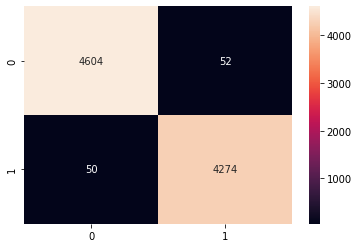

In [68]:

print('Confusion Matrix')
cm = confusion_matrix(y_test, predictions)
print(sns.heatmap(confusion_matrix(y_test, predictions),annot=True,fmt="d"))
print(classification_report(y_test, predictions, digits=5))

# Glove Exploration

In [69]:
X_train, X_test, y_train, y_test = train_test_split(data['text'],data['class'], test_size=0.2, random_state=111)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(35918,) (35918,) (8980,) (8980,)


In [70]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
words_to_index = tokenizer.word_index

In [71]:
def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)

  return word_to_vec_map

In [ ]:
word_to_vec_map = read_glove_vector('../input/glove6b100dtxt/glove.6B.100d.txt')
maxLen = 120

In [ ]:
vocab_len = len(words_to_index) + 1
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    emb_matrix[index, :] = embedding_vector

#embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)


In [ ]:
X_train_padded = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_padded, maxlen=maxLen, padding='post')
X_test_padded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_padded, maxlen=maxLen, padding='post')

In [ ]:
model = Sequential()
# define CNN model
#model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=120, weights = [emb_matrix], trainable=True))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
# define LSTM model
#model.add(Bidirectional(GRU(32, return_sequences=True)))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss = "binary_crossentropy",optimizer = optimizer,metrics = ["accuracy"])
filepath = 'my_checkpoint.ckpt'
cp = ModelCheckpoint(filepath=filepath,save_weights_only=True,save_best_only=True,monitor='val_accuracy',verbose=1)
ep = EarlyStopping(monitor='val_accuracy', patience=7)

In [ ]:
epochs=25
history = model.fit(
    X_train_padded, y_train,
    validation_split = 0.2,
    callbacks=[cp,ep],
    batch_size=128,
    epochs=epochs
)

Epoch 1/25
225/225 [==============================] - 7s 20ms/step - loss: 0.4107 - accuracy: 0.8088 - val_loss: 0.2496 - val_accuracy: 0.9035

Epoch 00001: val_accuracy improved from -inf to 0.90354, saving model to my_checkpoint.ckpt
Epoch 2/25
225/225 [==============================] - 3s 15ms/step - loss: 0.2337 - accuracy: 0.9107 - val_loss: 0.2086 - val_accuracy: 0.9182

Epoch 00002: val_accuracy improved from 0.90354 to 0.91815, saving model to my_checkpoint.ckpt
Epoch 3/25
225/225 [==============================] - 4s 16ms/step - loss: 0.1981 - accuracy: 0.9250 - val_loss: 0.1887 - val_accuracy: 0.9266

Epoch 00003: val_accuracy improved from 0.91815 to 0.92664, saving model to my_checkpoint.ckpt
Epoch 4/25
225/225 [==============================] - 3s 15ms/step - loss: 0.1737 - accuracy: 0.9346 - val_loss: 0.1807 - val_accuracy: 0.9304

Epoch 00004: val_accuracy improved from 0.92664 to 0.93040, saving model to my_checkpoint.ckpt
Epoch 5/25
225/225 [===========================

In [ ]:
model.evaluate(X_test_padded, y_test)

281/281 [==============================] - 1s 4ms/step - loss: 0.1360 - accuracy: 0.9673


[0.1359717696905136, 0.9672605991363525]

In [ ]:
predictions = (model.predict(X_test_padded) > 0.5).astype("int32")

In [ ]:
accuracy = accuracy_score(y_test, predictions)
print("Testing Accuracy: ", accuracy)

Testing Accuracy:  0.967260579064588


Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0    0.97745   0.95898   0.96813      4656
           1    0.95671   0.97618   0.96635      4324

    accuracy                        0.96726      8980
   macro avg    0.96708   0.96758   0.96724      8980
weighted avg    0.96746   0.96726   0.96727      8980



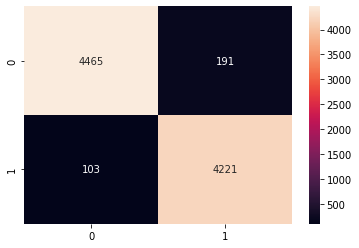

In [ ]:
print('Confusion Matrix')
cm = confusion_matrix(y_test, predictions)
print(sns.heatmap(confusion_matrix(y_test, predictions),annot=True,fmt="d"))
print(classification_report(y_test, predictions, digits=5))

# BERT Exploration

In [72]:
X_train, X_test, y_train, y_test = train_test_split(data['text'],data['class'], test_size=0.2, random_state=111)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(35918,) (35918,) (8980,) (8980,)


In [73]:
bert_abstract = ""
for sent in X_train:
    bert_abstract += sent +" "

len(bert_abstract)

88880413

In [74]:
!pip install transformers -U

     |████████████████████████████████| 3.4 MB 5.4 MB/s 
     |████████████████████████████████| 3.3 MB 24.8 MB/s 
     |████████████████████████████████| 61 kB 451 kB/s 
     |████████████████████████████████| 596 kB 45.3 MB/s 
     |████████████████████████████████| 895 kB 45.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')
input_ids = tf.constant(tokenizer.encode(bert_abstract))[None, :6000]
outputs = model(input_ids)
last_hidden_states = outputs[0]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
import numpy as np
emb_matrix = np.array(last_hidden_states)
emb_matrix = emb_matrix[0]
print(emb_matrix.shape)

(6000, 768)


In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
words_to_index = tokenizer.word_index

In [ ]:
maxLen = 120
X_train_padded = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_padded, maxlen=maxLen, padding='post')
X_test_padded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_padded, maxlen=maxLen, padding='post')

In [ ]:
model = Sequential()
# define CNN model
#model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Embedding(input_dim=6000, output_dim=768, input_length=120, weights = [emb_matrix], trainable=True))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=8, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(Bidirectional(GRU(32, return_sequences=True)))
#model.add(GRU(32, return_sequences=True))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(loss = "binary_crossentropy",optimizer = optimizer,metrics = ["accuracy"])
filepath = 'my_checkpoint.ckpt'
cp = ModelCheckpoint(filepath=filepath,save_weights_only=True,save_best_only=True,monitor='val_accuracy',verbose=1)
ep = EarlyStopping(monitor='val_accuracy', patience=7)

In [ ]:
epochs=25
history = model.fit(
    X_train_padded, y_train,
    validation_split = 0.2,
    callbacks=[cp,ep],
    batch_size=128,
    epochs=epochs
)

2021-12-29 19:21:34.190607: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2021-12-29 19:21:38.824731: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


225/225 [==============================] - 12s 23ms/step - loss: 0.5799 - accuracy: 0.6737 - val_loss: 0.4681 - val_accuracy: 0.7561

Epoch 00001: val_accuracy improved from -inf to 0.75612, saving model to my_checkpoint.ckpt
Epoch 2/25
225/225 [==============================] - 5s 20ms/step - loss: 0.2905 - accuracy: 0.8803 - val_loss: 0.1995 - val_accuracy: 0.9202

Epoch 00002: val_accuracy improved from 0.75612 to 0.92024, saving model to my_checkpoint.ckpt
Epoch 3/25
225/225 [==============================] - 4s 19ms/step - loss: 0.1857 - accuracy: 0.9303 - val_loss: 0.1489 - val_accuracy: 0.9433

Epoch 00003: val_accuracy improved from 0.92024 to 0.94335, saving model to my_checkpoint.ckpt
Epoch 4/25
225/225 [==============================] - 5s 20ms/step - loss: 0.1309 - accuracy: 0.9534 - val_loss: 0.1332 - val_accuracy: 0.9496

Epoch 00004: val_accuracy improved from 0.94335 to 0.94961, saving model to my_checkpoint.ckpt
Epoch 5/25
225/225 [==============================] - 4s 

In [ ]:
model.evaluate(X_test_padded, y_test)

281/281 [==============================] - 2s 6ms/step - loss: 0.0808 - accuracy: 0.9802


[0.08076272904872894, 0.98017817735672]

In [ ]:
predictions = (model.predict(X_test_padded) > 0.5).astype("int32")

Confusion Matrix
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0    0.98886   0.97272   0.98073      4656
           1    0.97114   0.98821   0.97960      4324

    accuracy                        0.98018      8980
   macro avg    0.98000   0.98046   0.98016      8980
weighted avg    0.98033   0.98018   0.98018      8980



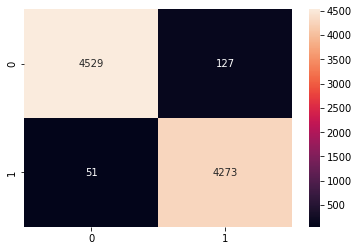

In [ ]:
print('Confusion Matrix')
cm = confusion_matrix(y_test, predictions)
print(sns.heatmap(confusion_matrix(y_test, predictions),annot=True,fmt="d"))
print(classification_report(y_test, predictions, digits=5))